# Linear Regression

## From Scratch

This section walks through building a complete linear regression implementation from scratch, covering the model, loss function, minibatch SGD optimizer, and training loop, then applying it to synthetic data. Although deep learning frameworks can automate these steps, implementing them manually builds a deeper understanding that is essential for customizing models in the future.

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### Model

Here, the model’s weights are initialized by sampling from a normal distribution with mean 0
and standard deviation 0.01.


In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    #module class need to have forward and loss func defined.
    """The linear regression model implemented from scratch.
    num_inputs = number of examples"""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)   
        self.b = torch.zeros(1, requires_grad=True)

In [ ]:
class LinearRegressionScratch(d2l.Module):
    """num_inputs = number of examples"""ArithmeticError
    def __init__(self, num_inputs, lr, sigma=0.1):
        # `super().__init__()` is calling the constructor of the parent class of `LinearRegressionScratch`, which in this case is `d2l.Module`. This allows the `LinearRegressionScratch` class to inherit and initialize attributes and methods from its parent class.
        super().__init__()
        self.save_hyperparameters()
        # This line of code is initializing the weight parameter `w` for the linear regression model. It is using `torch.normal` to generate random values from a normal distribution with mean 0 and standard deviation `sigma`. The shape of the tensor is `(num_inputs, 1)` which corresponds to the number of input features and the output dimension of the linear regression model. The parameter `requires_grad=True` indicates that gradients with respect to this tensor will be computed during backpropagation for training the model.
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)

Next, we define the model, specifying how the inputs and parameters are mathematically combined to produce the output.

In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):   #forward method
    return torch.matmul(X, self.w) + self.b

In [4]:
# add additional methods or attributes to 'LinearRegressionScratch' class in the cosebase
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):   #forward method
    return torch.matmul(X, self.w) + self.b 

### Loss Function

Here we use the squared loss function.

In [5]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2    #y_hat = pred; y = true
    return l.mean() #want average loss on the batch

### Optimization Algorithm

We define a SGD class and make an instance of it. 

In [6]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent.
    Input: model params and LR"""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self): #num of times you updates weights
        for param in self.params:
            param -= self.lr * param.grad   #update by subtracting lr * grad 

    def zero_grad(self):    # zero out grad when finish 1 loop
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [9]:
# add configure_optimizers to class LinearregressionScratch to perform SGD
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)   #call SGD by passing weight and biases and lr.

### Training

With the parameters, loss function, model, and optimizer defined, we can now implement the main training loop to fit the model to the data.

In [10]:
# add methods/attributes to d2l.Trainer class
@d2l.add_to_class(d2l.Trainer)  #@save
# use this Trainer class

# --- where you do training ----- #
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()  #calling model here
    for batch in self.train_dataloader:
        # 1. Compute loss
        loss = self.model.training_step(self.prepare_batch(batch))  #F.P.
        #2. Clean grad = 0 
        self.optim.zero_grad()
        with torch.no_grad():   #when don want to track grad
            # 3. Compute B.P.
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            # 4. Call optimizers and update weight
            self.optim.step()
        self.train_batch_idx += 1
    # 6. (optical but important) add validation test
    if self.val_dataloader is None:
        return
    # 7. Evaluate current model eval(): take your val data and evaluate model with current set of params
    self.model.eval()
    for batch in self.val_dataloader:
        #2. no gradient tracking in validation phase
        with torch.no_grad():
            # 8. call validation step and the batch
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Note that in general, both the number of epochs and the learning rate are `hyperparameters`. In general, setting hyperparameters is tricky and we will usually want to use a three-way split, one set for training, a second for hyperparameter selection, and the third reserved for the final evaluation. 

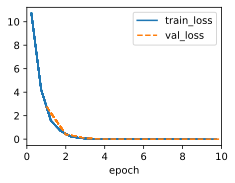

In [11]:
model = LinearRegressionScratch(2, lr=0.03) #model is defined as LRonS
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)    
trainer = d2l.Trainer(max_epochs=10) #train for 3 epochs
trainer.fit(model, data)

In [12]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0003, -0.0006])
error in estimating b: tensor([0.0002])


## Exercises

1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

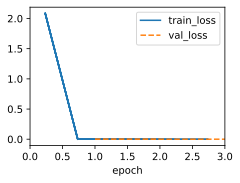

In [13]:
model = LinearRegressionScratch(2, lr=0.3) #model is defined as LRonS
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)    
trainer = d2l.Trainer(max_epochs=3) #train for 3 epochs
trainer.fit(model, data)

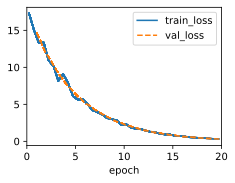

In [14]:
model = LinearRegressionScratch(2, lr=0.003) #model is defined as LRonS
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)    
trainer = d2l.Trainer(max_epochs=20) #train for 3 epochs
trainer.fit(model, data)
# find a way to print out epoch

2. If the number of examples cannot be divided by the batch size, what happens to data_iter at the end of an epoch?

## Concise Implementation

In this section, we demonstrate a concise implementation of the linear regression model using high-level deep learning APIs. These abstractions streamline the code while preserving the same structure and logic as the from-scratch version.

In [15]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### Model

Now we use a framework’s predefined layers, enabling us to focus on selecting and arranging the model’s layers without dealing with their low-level implementation details.

In [16]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [17]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)  #PyTorch takes auto LazyLinear 

### Loss Function

Again, we use pre-defined loss function.

In [18]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

### Optimization Algorithm

Minibatch SGD is a common optimization method for training neural networks, and PyTorch’s optim module provides built-in support for it along with several variations of the algorithm.

In [19]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

### Training

Now that we have all the basic pieces in place, the training loop itself is the same as the one we implemented from scratch.

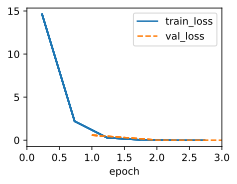

In [20]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [21]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([-0.0004, -0.0117])
error in estimating b: tensor([0.0122])


## Exercises

Ex. 3:

Consider the following definitions and then answer the question:
- __Aggregate loss__ (sum): the minibatch loss is defined by the sum of the individual sample losses.
- __Average loss__ (mean): the minibatch loss is defined as the mean of the sample losses (so the sum devided by the minibatch size).

How would you need to change the learning rate if you replace the aggregate loss with an average loss?

Ex. 4:

How do you access the gradient of the weights of the model?

Ex. 5:

Replace the squared loss with Huber’s robust loss function and run the training again. You can uncomment the line below to read more about the nn.HuberLoss available pytorch.

In [ ]:
# nn.HuberLoss?